# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc.pilutil import imread, imresize
from imageio import imread
import datetime
import os
import abc
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
batch_size = 32 #experiment with the batch size

In [4]:
print(len(train_doc))
print(len(val_doc))

663
663


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self):
        self.train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
        self.val_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
        self.train_path = './Project_data/train'
        self.val_path =  './Project_data/train'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=imresize(image,(self.image_height,self.image_width,3))
                #image_resized=np.array(Image.fromarray(image).resize(self.image_height,self.image_width,3))
                #image_resized=Image.fromarray(image).resize(size=(self.image_height,self.image_width),mode='RGB')
                # Image resize of numpy as it is deprecated from scipy.misc
                image_resized=np.array(Image.fromarray((image).astype(np.uint8)).resize((self.image_height,self.image_width)).convert('RGB'))
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    #image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    #image_resized=np.array(Image.fromarray(cropped).resize(size=(self.image_height,self.image_width),mode='RGB'))
                    # Image resize of numpy as it is deprecated from scipy.misc
                    image_resized=np.array(Image.fromarray((cropped).astype(np.uint8)).resize((self.image_height,self.image_width)).convert('RGB'))
        
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [55]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Dropout

In [7]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [8]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d_model=conv_3d.define_model()
conv_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

## Sample Cropping 

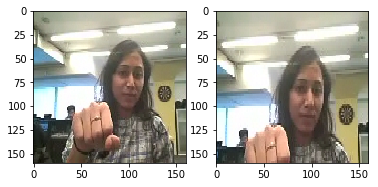

In [9]:
test_generator=ModelConv3D()
test_generator.initialize_path()
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:]) 

In [10]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=100,image_width=100)
conv_3d.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 202s 9s/step - loss: 1.8241 - categorical_accuracy: 0.3542 - val_loss: 1.8291 - val_categorical_accuracy: 0.4314

Epoch 00001: val_loss improved from inf to 1.82908, saving model to model_init_2020-09-1304_03_46.016724/model-00001-1.76117-0.36802-1.82908-0.43137.h5
Epoch 2/2
23/23 [==============================] - 82s 4s/step - loss: 1.1584 - categorical_accuracy: 0.5415 - val_loss: 1.2387 - val_categorical_accuracy: 0.5339

Epoch 00002: val_loss improved from 1.82908 to 1.23866, saving model to model_init_2020-09-1304_03_46.016724/model-00002-1.11364-0.56259-1.23866-0.53394.h5


In [11]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=100,image_width=100)
conv_3d.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 84s 7s/step - loss: 1.9366 - categorical_accuracy: 0.3683 - val_loss: 1.4665 - val_categorical_accuracy: 0.5370

Epoch 00001: val_loss improved from inf to 1.46653, saving model to model_init_2020-09-1304_08_35.804863/model-00001-1.82164-0.37104-1.46653-0.53695.h5
Epoch 2/2
12/12 [==============================] - 75s 6s/step - loss: 1.1224 - categorical_accuracy: 0.5548 - val_loss: 1.1123 - val_categorical_accuracy: 0.6094

Epoch 00002: val_loss improved from 1.46653 to 1.11233, saving model to model_init_2020-09-1304_08_35.804863/model-00002-1.17414-0.54600-1.11233-0.60935.h5


In [12]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=100,image_width=100)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 46s 4s/step - loss: 1.6807 - categorical_accuracy: 0.3481 - val_loss: 1.2661 - val_categorical_accuracy: 0.5430

Epoch 00001: val_loss improved from inf to 1.26610, saving model to model_init_2020-09-1304_12_00.700928/model-00001-1.67603-0.37557-1.26610-0.54299.h5
Epoch 2/2
12/12 [==============================] - 39s 3s/step - loss: 1.1500 - categorical_accuracy: 0.5333 - val_loss: 1.0858 - val_categorical_accuracy: 0.6109

Epoch 00002: val_loss improved from 1.26610 to 1.08577, saving model to model_init_2020-09-1304_12_00.700928/model-00002-1.12452-0.54902-1.08577-0.61086.h5


In [13]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=100,image_width=100)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - 47s 5s/step - loss: 1.6868 - categorical_accuracy: 0.3778 - val_loss: 2.8138 - val_categorical_accuracy: 0.3710

Epoch 00001: val_loss improved from inf to 2.81382, saving model to model_init_2020-09-1304_13_33.593359/model-00001-1.68667-0.38009-2.81382-0.37104.h5
Epoch 2/2
9/9 [==============================] - 37s 4s/step - loss: 1.0592 - categorical_accuracy: 0.6124 - val_loss: 1.8270 - val_categorical_accuracy: 0.4223

Epoch 00002: val_loss improved from 2.81382 to 1.82700, saving model to model_init_2020-09-1304_13_33.593359/model-00002-1.07003-0.60935-1.82700-0.42232.h5


In [14]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=100,image_width=100)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 57s 856ms/step - loss: 1.6577 - categorical_accuracy: 0.3796 - val_loss: 1.3295 - val_categorical_accuracy: 0.5113

Epoch 00001: val_loss improved from inf to 1.32954, saving model to model_init_2020-09-1304_15_06.936613/model-00001-1.66089-0.38009-1.32954-0.51131.h5
Epoch 2/2
67/67 [==============================] - 52s 775ms/step - loss: 1.2029 - categorical_accuracy: 0.5458 - val_loss: 0.8386 - val_categorical_accuracy: 0.6561

Epoch 00002: val_loss improved from 1.32954 to 0.83862, saving model to model_init_2020-09-1304_15_06.936613/model-00002-1.20838-0.54449-0.83862-0.65611.h5


In [15]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=100,image_width=100)
conv_3d.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 104s 2s/step - loss: 1.6594 - categorical_accuracy: 0.3890 - val_loss: 1.2721 - val_categorical_accuracy: 0.5279

Epoch 00001: val_loss improved from inf to 1.27205, saving model to model_init_2020-09-1304_17_01.899615/model-00001-1.66205-0.38612-1.27205-0.52790.h5
Epoch 2/2
67/67 [==============================] - 96s 1s/step - loss: 1.2299 - categorical_accuracy: 0.5244 - val_loss: 0.8593 - val_categorical_accuracy: 0.6863

Epoch 00002: val_loss improved from 1.27205 to 0.85927, saving model to model_init_2020-09-1304_17_01.899615/model-00002-1.23104-0.52640-0.85927-0.68627.h5


In [16]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 70s 3s/step - loss: 1.7876 - categorical_accuracy: 0.3804 - val_loss: 1.3946 - val_categorical_accuracy: 0.5641

Epoch 00001: val_loss improved from inf to 1.39461, saving model to model_init_2020-09-1304_20_28.798684/model-00001-1.72095-0.39517-1.39461-0.56410.h5
Epoch 2/3
23/23 [==============================] - 52s 2s/step - loss: 1.0425 - categorical_accuracy: 0.6121 - val_loss: 1.0160 - val_categorical_accuracy: 0.6667

Epoch 00002: val_loss improved from 1.39461 to 1.01598, saving model to model_init_2020-09-1304_20_28.798684/model-00002-1.01416-0.62293-1.01598-0.66667.h5
Epoch 3/3
23/23 [==============================] - 53s 2s/step - loss: 0.8534 - categorical_accuracy: 0.6826 - val_loss: 0.5463 - val_categorical_accuracy: 0.8100

Epoch 00003: val_loss improved from 1.01598 to 0.54633, saving model to model_init_2020-09-1304_20_28.798684/model-00003-0.84767-0.68326-0.54633-0.80995.h5


In [17]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 130s 3s/step - loss: 1.5280 - categorical_accuracy: 0.4340 - val_loss: 1.0532 - val_categorical_accuracy: 0.5988

Epoch 00001: val_loss improved from inf to 1.05323, saving model to model_init_2020-09-1304_23_32.154656/model-00001-1.53474-0.42986-1.05323-0.59879.h5
Epoch 2/2
45/45 [==============================] - 111s 2s/step - loss: 0.9693 - categorical_accuracy: 0.6428 - val_loss: 0.9838 - val_categorical_accuracy: 0.6682

Epoch 00002: val_loss improved from 1.05323 to 0.98375, saving model to model_init_2020-09-1304_23_32.154656/model-00002-0.98012-0.63650-0.98375-0.66817.h5


In [18]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 68s 2s/step - loss: 1.5391 - categorical_accuracy: 0.4605 - val_loss: 1.3545 - val_categorical_accuracy: 0.5249

Epoch 00001: val_loss improved from inf to 1.35454, saving model to model_init_2020-09-1304_27_41.078697/model-00001-1.56005-0.45098-1.35454-0.52489.h5
Epoch 2/2
45/45 [==============================] - 60s 1s/step - loss: 1.1609 - categorical_accuracy: 0.5661 - val_loss: 0.8108 - val_categorical_accuracy: 0.6923

Epoch 00002: val_loss improved from 1.35454 to 0.81083, saving model to model_init_2020-09-1304_27_41.078697/model-00002-1.14245-0.57617-0.81083-0.69231.h5


In [19]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - 72s 1s/step - loss: 1.5064 - categorical_accuracy: 0.4398 - val_loss: 0.8224 - val_categorical_accuracy: 0.6817

Epoch 00001: val_loss improved from inf to 0.82238, saving model to model_init_2020-09-1304_29_57.109020/model-00001-1.50369-0.43741-0.82238-0.68175.h5
Epoch 2/2
67/67 [==============================] - 64s 952ms/step - loss: 1.1106 - categorical_accuracy: 0.5696 - val_loss: 0.9393 - val_categorical_accuracy: 0.6486

Epoch 00002: val_loss did not improve from 0.82238


In [20]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - 66s 4s/step - loss: 1.6803 - categorical_accuracy: 0.3980 - val_loss: 1.3484 - val_categorical_accuracy: 0.5324

Epoch 00001: val_loss improved from inf to 1.34844, saving model to model_init_2020-09-1304_32_20.827860/model-00001-1.67952-0.39819-1.34844-0.53243.h5
Epoch 2/2
17/17 [==============================] - 46s 3s/step - loss: 1.0374 - categorical_accuracy: 0.5908 - val_loss: 0.7204 - val_categorical_accuracy: 0.7255

Epoch 00002: val_loss improved from 1.34844 to 0.72037, saving model to model_init_2020-09-1304_32_20.827860/model-00002-1.03318-0.58824-0.72037-0.72549.h5


In [21]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=20,batch_size=50,num_epochs=3)
conv_3d_model=conv_3d.define_model()
print("Total Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total Params: 1736389
Epoch 1/3


ResourceExhaustedError: OOM when allocating tensor with shape[50,16,20,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_11/Adam/gradients/max_pooling3d_49/MaxPool3D_grad/MaxPool3DGrad = MaxPool3DGrad[T=DT_FLOAT, TInput=DT_FLOAT, _class=["loc:@train.../cond_grad"], data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_73/cond/Merge, max_pooling3d_49/MaxPool3D, training_11/Adam/gradients/conv3d_50/convolution_grad/Conv3DBackpropInputV2)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [22]:
print("Memory util is {} Gigas". format(getsizeof(np.zeros((50,16,20,160,160)))/(1024*1024*1024)))

Memory util is 3.051757961511612 Gigas


In [23]:
print("Memory util is {} Gigas". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigas


#### We had limit on memory resources with image resolution 160x160 with 30 frames , batch size 40 

### Model 1: Starting with Model Batch 40 and no of epochs 15

In [24]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self,filtersize,dense_neurons,dropout):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d_model=conv_3d.define_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25)
conv_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_54 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 10, 80, 80, 32)    128       
__________

In [26]:
print("Total Params:", conv_3d_model.count_params())
history_model1 = conv_3d.train_model(conv_3d_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 87s 5s/step - loss: 1.6393 - categorical_accuracy: 0.4119 - val_loss: 8.6884 - val_categorical_accuracy: 0.2157

Epoch 00001: val_loss improved from inf to 8.68840, saving model to model_init_2020-09-1304_38_15.701119/model-00001-1.63906-0.41026-8.68840-0.21569.h5
Epoch 2/15
17/17 [==============================] - 62s 4s/step - loss: 1.1239 - categorical_accuracy: 0.5889 - val_loss: 3.9695 - val_categorical_accuracy: 0.3454

Epoch 00002: val_loss improved from 8.68840 to 3.96949, saving model to model_init_2020-09-1304_38_15.701119/model-00002-1.12802-0.58522-3.96949-0.34540.h5
Epoch 3/15
17/17 [==============================] - 67s 4s/step - loss: 0.8626 - categorical_accuracy: 0.6815 - val_loss: 0.6886 - val_categorical_accuracy: 0.7285

Epoch 00003: val_loss improved from 3.96949 to 0.68861, saving model to model_init_2020-09-1304_38_15.701119/model-00003-0.86269-0.68326-0.68861-0.72851.h5
Epoch 4/15
17/17 [=

In [27]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

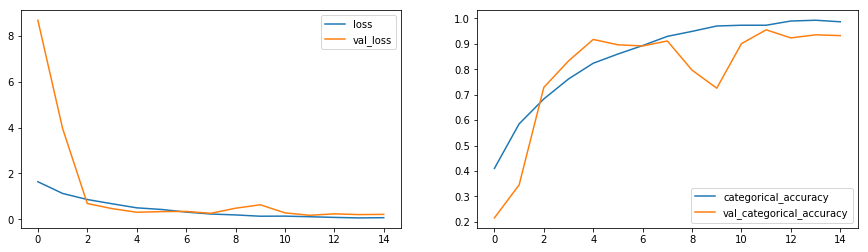

In [28]:
plot(history_model1)

### Model is overfitting !!!

### Model 2: Modifying drop out to 0.5, increasing neuron density, Batch 20 and no of epochs 15

In [29]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=15)
conv_3d_model=conv_3d.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_57 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_58 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 10, 80, 80, 32)    128       
__________

In [30]:
print("Total Params:", conv_3d_model.count_params())
history_model2=conv_3d.train_model(conv_3d_model,augment_data=True)

Total Params: 3638981
Epoch 1/15
34/34 [==============================] - 139s 4s/step - loss: 1.8767 - categorical_accuracy: 0.4088 - val_loss: 1.1506 - val_categorical_accuracy: 0.5958

Epoch 00001: val_loss improved from inf to 1.15059, saving model to model_init_2020-09-1304_54_58.446133/model-00001-1.88286-0.40649-1.15059-0.59578.h5
Epoch 2/15
34/34 [==============================] - 111s 3s/step - loss: 1.4473 - categorical_accuracy: 0.4882 - val_loss: 0.9818 - val_categorical_accuracy: 0.7104

Epoch 00002: val_loss improved from 1.15059 to 0.98177, saving model to model_init_2020-09-1304_54_58.446133/model-00002-1.43790-0.49623-0.98177-0.71041.h5
Epoch 3/15
34/34 [==============================] - 115s 3s/step - loss: 1.2111 - categorical_accuracy: 0.5802 - val_loss: 2.3592 - val_categorical_accuracy: 0.4646

Epoch 00003: val_loss did not improve from 0.98177
Epoch 4/15
34/34 [==============================] - 110s 3s/step - loss: 1.0618 - categorical_accuracy: 0.6247 - val_loss

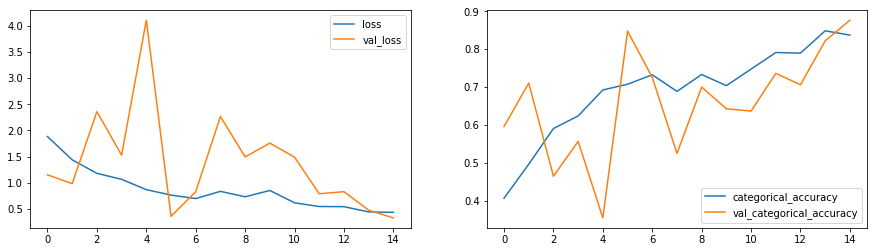

In [31]:
plot(history_model2)

### val_loss did not improve from 0.35713

### Model 3: Introducing learning rate as 0.0002, reducing filter size to (2,2,2), batch size 30 and Number of Epochs 15

In [32]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self,filtersize,dense_neurons,dropout):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=120,image_width=120)
conv_3d.initialize_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=15)
conv_3d_model=conv_3d.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_61 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_62 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_92 (Batc (None, 10, 60, 60, 32)    128       
__________

In [34]:
print("Total Params:", conv_3d_model.count_params())
history_model3=conv_3d.train_model(conv_3d_model,augment_data=True)

Total Params: 1762613
Epoch 1/15
23/23 [==============================] - 111s 5s/step - loss: 2.2679 - categorical_accuracy: 0.3079 - val_loss: 1.2238 - val_categorical_accuracy: 0.5324

Epoch 00001: val_loss improved from inf to 1.22379, saving model to model_init_2020-09-1305_24_07.320372/model-00001-2.26586-0.30694-1.22379-0.53243.h5
Epoch 2/15
23/23 [==============================] - 78s 3s/step - loss: 1.5012 - categorical_accuracy: 0.4955 - val_loss: 0.7376 - val_categorical_accuracy: 0.7315

Epoch 00002: val_loss improved from 1.22379 to 0.73764, saving model to model_init_2020-09-1305_24_07.320372/model-00002-1.53851-0.47587-0.73764-0.73152.h5
Epoch 3/15
23/23 [==============================] - 90s 4s/step - loss: 1.3079 - categorical_accuracy: 0.5404 - val_loss: 0.6588 - val_categorical_accuracy: 0.7903

Epoch 00003: val_loss improved from 0.73764 to 0.65880, saving model to model_init_2020-09-1305_24_07.320372/model-00003-1.33332-0.53544-0.65880-0.79035.h5
Epoch 4/15
23/23 [

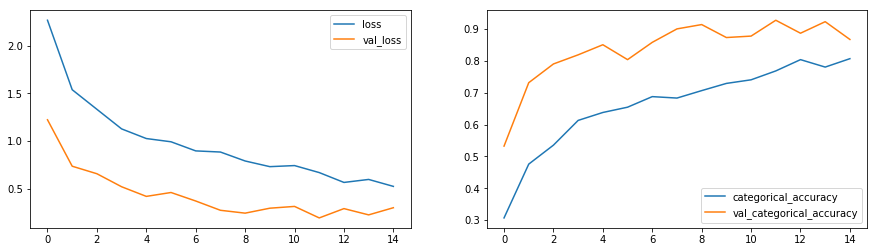

In [36]:
plot(history_model3)

### Model has a validation accuracy of : 86.73%  and training accuracy of: 81.42%

### Model 4: Adding more layers, batch size 20 and Number of Epochs 15

In [37]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self,filtersize,dense_neurons,dropout):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=120,image_width=120)
conv_3d.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=15)
conv_3d_model=conv_3d.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_65 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_66 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 10, 60, 60, 16)    0         
__________

In [39]:
print("Total Params:", conv_3d_model.count_params())
history_model4=conv_3d.train_model(conv_3d_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 161s 5s/step - loss: 1.9631 - categorical_accuracy: 0.3767 - val_loss: 3.0601 - val_categorical_accuracy: 0.4314

Epoch 00001: val_loss improved from inf to 3.06014, saving model to model_init_2020-09-1305_49_31.828855/model-00001-1.97793-0.37783-3.06014-0.43137.h5
Epoch 2/15
34/34 [==============================] - 135s 4s/step - loss: 1.5045 - categorical_accuracy: 0.5011 - val_loss: 4.3514 - val_categorical_accuracy: 0.3348

Epoch 00002: val_loss did not improve from 3.06014
Epoch 3/15
34/34 [==============================] - 135s 4s/step - loss: 1.2053 - categorical_accuracy: 0.5843 - val_loss: 2.9394 - val_categorical_accuracy: 0.4238

Epoch 00003: val_loss improved from 3.06014 to 2.93939, saving model to model_init_2020-09-1305_49_31.828855/model-00003-1.20871-0.58220-2.93939-0.42383.h5
Epoch 4/15
34/34 [==============================] - 136s 4s/step - loss: 1.0487 - categorical_accuracy: 0.6277 - val_loss

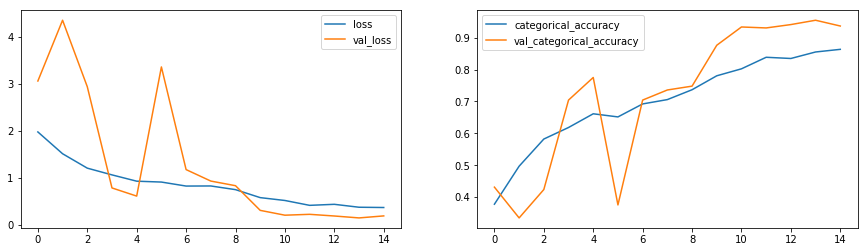

In [40]:
plot(history_model4)

### There is a bit performance improvement with more layers with training accuracy 85.87% and validation accuracy 93.67%

### Model 5: Adding dropout at convolution layers

In [45]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self,filtersize,dense_neurons,dropout):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=120,image_width=120)
conv_3d.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=15)
conv_3d_model=conv_3d.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_73 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_73 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_107 (Bat (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_74 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_74 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_108 (Bat (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 10, 60, 60, 16)    0         
__________

In [43]:
print("Total Params:", conv_3d_model.count_params())
history_model5=conv_3d.train_model(conv_3d_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 152s 4s/step - loss: 2.2373 - categorical_accuracy: 0.3024 - val_loss: 2.3099 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 2.30993, saving model to model_init_2020-09-1306_24_02.000048/model-00001-2.21314-0.30995-2.30993-0.26998.h5
Epoch 2/15
34/34 [==============================] - 136s 4s/step - loss: 1.7317 - categorical_accuracy: 0.4003 - val_loss: 4.6788 - val_categorical_accuracy: 0.2066

Epoch 00002: val_loss did not improve from 2.30993
Epoch 3/15
34/34 [==============================] - 137s 4s/step - loss: 1.6183 - categorical_accuracy: 0.4297 - val_loss: 2.5699 - val_categorical_accuracy: 0.2821

Epoch 00003: val_loss did not improve from 2.30993
Epoch 4/15
34/34 [==============================] - 136s 4s/step - loss: 1.4446 - categorical_accuracy: 0.4801 - val_loss: 2.0922 - val_categorical_accuracy: 0.3469

Epoch 00004: val_loss improved from 2.30993 to 2.09221, savi

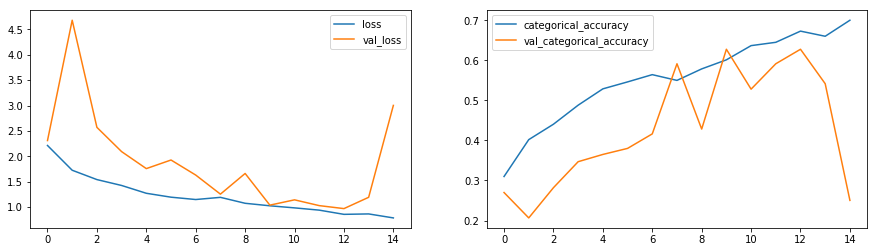

In [44]:
plot(history_model5)

### Overfitting again!! Adding dropouts has further reduced validation accuracy drastically as the model doesn't seem to generalise well.
### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

### Model 6: Reducing number of parameter in number of neurons, image size and drop out

In [46]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self,dense_neurons,dropout):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=100,image_width=100)
conv_3d.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=15)
conv_3d_model=conv_3d.define_model(dense_neurons=128,dropout=0.25)
conv_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_81 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation_81 (Activation)   (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_117 (Bat (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_82 (Conv3D)           (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_82 (Activation)   (None, 10, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_118 (Bat (None, 10, 50, 50, 32)    128       
__________

In [48]:
print("Total Params:", conv_3d_model.count_params())
history_model6=conv_3d.train_model(conv_3d_model,augment_data=True)

Total Params: 696645
Epoch 1/15
34/34 [==============================] - 113s 3s/step - loss: 1.7283 - categorical_accuracy: 0.3764 - val_loss: 1.0244 - val_categorical_accuracy: 0.6109

Epoch 00001: val_loss improved from inf to 1.02445, saving model to model_init_2020-09-1307_00_39.785182/model-00001-1.70240-0.38160-1.02445-0.61086.h5
Epoch 2/15
34/34 [==============================] - 87s 3s/step - loss: 1.1853 - categorical_accuracy: 0.5453 - val_loss: 0.7000 - val_categorical_accuracy: 0.7195

Epoch 00002: val_loss improved from 1.02445 to 0.70004, saving model to model_init_2020-09-1307_00_39.785182/model-00002-1.15697-0.55053-0.70004-0.71946.h5
Epoch 3/15
34/34 [==============================] - 88s 3s/step - loss: 0.9185 - categorical_accuracy: 0.6549 - val_loss: 0.4160 - val_categorical_accuracy: 0.8462

Epoch 00003: val_loss improved from 0.70004 to 0.41604, saving model to model_init_2020-09-1307_00_39.785182/model-00003-0.90420-0.65460-0.41604-0.84615.h5
Epoch 4/15
34/34 [=

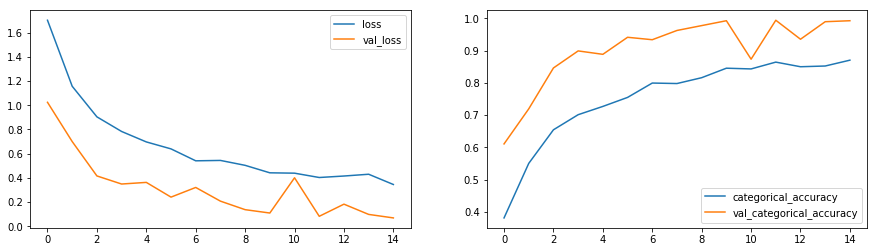

In [49]:
plot(history_model6)

### With less number of trainable parameter less memory is used with validation accuracy of 99.25%

### Model 7: CNN - LSTM Model

In [50]:
class RNNCNN(ModelBuilder):
    
    def define_model(self,lstm_cells,dense_neurons,dropout):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [56]:
rnn_cnn=RNNCNN()
rnn_cnn.initialize_path()
rnn_cnn.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=15)
rnn_cnn_model=rnn_cnn.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [57]:
print("Total Params:", rnn_cnn_model.count_params())
history_model7=rnn_cnn.train_model(rnn_cnn_model,augment_data=True)

Total Params: 1657445
Epoch 1/15
34/34 [==============================] - 142s 4s/step - loss: 1.3820 - categorical_accuracy: 0.3878 - val_loss: 1.3036 - val_categorical_accuracy: 0.4284

Epoch 00001: val_loss improved from inf to 1.30360, saving model to model_init_2020-09-1307_28_56.831473/model-00001-1.37651-0.38914-1.30360-0.42836.h5
Epoch 2/15
34/34 [==============================] - 83s 2s/step - loss: 1.0885 - categorical_accuracy: 0.5589 - val_loss: 0.9677 - val_categorical_accuracy: 0.6229

Epoch 00002: val_loss improved from 1.30360 to 0.96765, saving model to model_init_2020-09-1307_28_56.831473/model-00002-1.09376-0.55204-0.96765-0.62293.h5
Epoch 3/15
34/34 [==============================] - 87s 3s/step - loss: 0.9993 - categorical_accuracy: 0.6038 - val_loss: 0.8651 - val_categorical_accuracy: 0.6576

Epoch 00003: val_loss improved from 0.96765 to 0.86511, saving model to model_init_2020-09-1307_28_56.831473/model-00003-1.00526-0.60633-0.86511-0.65762.h5
Epoch 4/15
34/34 [

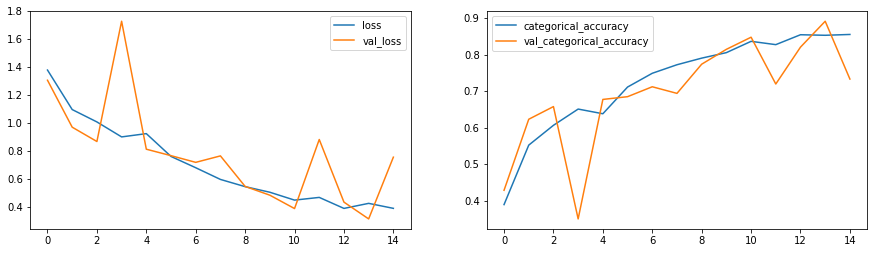

In [58]:
plot(history_model7)

### For CNN - LSTM model we get a best validation accuracy of 89.14% and tranning accuracy of 84.84%

### Tina Ghosh
### Siddhant Sambit